# Exercise: Insights

- A Studio that produces movies asked us whether we could provide valuable (for them) insights based on our data.

- Also, our procurement team, ie the team that signs new studios and new films, asked us whether we could help them make data-driven decisions on what films to sign next.

In [44]:
import re
from datetime import datetime
import numpy as np
import pandas as pd
import dask.dataframe as dd

# visualization imports
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from wordcloud import WordCloud

%matplotlib inline

In [45]:
movies_df = pd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
ratings_df = pd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
tags_df = pd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

In [33]:
#add dummy inisghts from expl analysis
#how many movies are rated?
len(ratings_df.movieId.unique())

#how many movies are tagged?
#number of movies with tags

len(tags_df.movieId.unique())

#how many users

#what is the oldest movie

#what is the latest movie

45981

Extract and Transform data 

In [46]:
movies_df

#adjust title name
# movies_df.loc[47763, "title"] = "The Devotion of Suspect X (2017)"

#add movie year column
# movies_df["movie_year"] = movies_df.title.str.findall(r"\((\d\d\d\d)\)").apply(','.join) 
movies_df["movie_year"] = movies_df.title.str.extract(r"\((\d{4})\)(?!.*\(\d{4}\))")
movies_df["movie_year"] = pd.to_numeric(movies_df.movie_year, downcast="integer", errors="coerce")
# modify two values due to error in movie title
# movies_df.at[89398, "movie_year"] = 2017
# movies_df.at[9775250, "movie_year"] = 2017
#split movie genres and organize them into a list (will be handy later) 
movies_df["genres"] = movies_df["genres"].str.split("|")
# movies_df["genres"] = movies_df["genres"].str.replace("|", ", ", regex=True)

#create function that selects start and end time interval and appends:
#if none -> all times
#average ratings
#all views

#generate visuals
#avg ratings for top 10 movies
#views start-end time int for top 10 movies
#create function to
#get all tags for top rated movies queried

In [47]:
movies_df

,movieId,title,genres,movie_year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0
...,...,...,...,...
58093,193876,The Great Glinka (1946),[(no genres listed)],1946.0
58094,193878,Les tribulations d'une caissière (2011),[Comedy],2011.0
58095,193880,Her Name Was Mumu (2016),[Drama],2016.0
58096,193882,Flora (2017),"[Adventure, Drama, Horror, Sci-Fi]",2017.0


In [41]:
movies_df[movies_df.movie_year.isna()]

,movieId,title,genres,movie_year
10023,32930,Category 6: Day of Destruction,"[Action, Drama]",NaN
10613,40697,Babylon 5,[Sci-Fi],NaN
15719,79607,"Millions Game, The (Das Millionenspiel)","[Action, Drama, Sci-Fi, Thriller]",NaN
17444,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",[Documentary],NaN
22651,107434,Diplomatic Immunity (2009– ),[Comedy],NaN
...,...,...,...,...
57504,192339,The Sign of Three,[(no genres listed)],NaN
57674,192829,Parwaaz Hai Junoon,"[Adventure, Children, Romance]",NaN
57789,193149,¿Qué te juegas?,[(no genres listed)],NaN
57903,193443,Wall,[(no genres listed)],NaN


Merge datasets

In [48]:
dd_movies = dd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
dd_ratings = dd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
dd_tags = dd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

In [49]:
dd_user_info = dd.merge(dd_ratings, dd_tags, how="left", on=["userId", "movieId"], suffixes=("_rating", "_tag"))

In [50]:
df_user_info = dd_user_info.compute()

In [ ]:
#add datetime columns -
# look for seasonality - timeseries

In [51]:
dd_complete = dd.merge(df_user_info, dd_movies, how="left", on="movieId")

In [52]:
df_complete = dd_complete.compute()

In [ ]:
df_complete.describe()

In [53]:
#can we use dask for this?

df_complete["datetime_rating"] = pd.to_datetime(df_complete["timestamp_rating"], unit="s")
df_complete["datetime_tag"] = pd.to_datetime(df_complete["timestamp_tag"], unit="s")
df_complete["genres"] = df_complete["genres"].str.split("|")
df_complete["movie_year"] = df_complete.title.str.extract(r"\((\d{4})\)(?!.*\(\d{4}\))")
df_complete["movie_year"] = pd.to_numeric(df_complete.movie_year, downcast="integer", errors="coerce")

In [57]:
df_complete

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year
0,1,307,3.5,1256677221,NaN,NaN,Three Colors: Blue (Trois couleurs: Bleu) (1993),[Drama],2009-10-27 21:00:21,NaT,1993.0
1,106361,8368,3.5,1501871808,NaN,NaN,Harry Potter and the Prisoner of Azkaban (2004),"[Adventure, Fantasy, IMAX]",2017-08-04 18:36:48,NaT,2004.0
2,131346,4816,1.5,1433273308,NaN,NaN,Zoolander (2001),[Comedy],2015-06-02 19:28:28,NaT,2001.0
3,206877,208,4.0,854979504,NaN,NaN,Waterworld (1995),"[Action, Adventure, Sci-Fi]",1997-02-03 14:18:24,NaT,1995.0
4,53456,1777,3.0,945051094,NaN,NaN,"Wedding Singer, The (1998)","[Comedy, Romance]",1999-12-13 02:11:34,NaT,1998.0
...,...,...,...,...,...,...,...,...,...,...,...
28363491,27045,260,5.0,955118461,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",2000-04-07 14:41:01,NaT,1977.0
28363492,27045,317,5.0,955121387,NaN,NaN,"Santa Clause, The (1994)","[Comedy, Drama, Fantasy]",2000-04-07 15:29:47,NaT,1994.0
28363493,27045,349,4.0,955119023,NaN,NaN,Clear and Present Danger (1994),"[Action, Crime, Drama, Thriller]",2000-04-07 14:50:23,NaT,1994.0
28363494,27045,367,4.0,955121417,NaN,NaN,"Mask, The (1994)","[Action, Comedy, Crime, Fantasy]",2000-04-07 15:30:17,NaT,1994.0


In [ ]:
dataset = df_complete.copy()

In [58]:
#filter from start and end date

#if start is not None:

# filter dataset.datetime_rating > start date

#if end is not None:

#filter dataset.datetime_rating < end date

# return filtered dataset

def filter_start(df, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Use to filter the dataset based on time interval. 
    """
    return df.loc[(df.datetime_rating >= start_date) & (df.datetime_rating <= end_date)].sort_values(by= "datetime_rating", ascending= False)

#--

# filter production date

# filter_production_date(dataset, start_year, end_year):
# return dataset.loc[(dataset.movie_year >= start_year) & (dataset.movie_year <= end_year)]

# get_views(dataset, start, end, prod_start, prod_end)

# filtered_df = filter_startend(dataset)

# filtered_df = filter_production_date(filtered_df, prod_start, prod_end)

def filter_production_date(df, prod_start, prod_end):
    """
    Use to filter the dataset based on production movie year
    """
    return df.loc[(df.movie_year >= prod_start) & (df.movie_year <= prod_end)]

# insights_df = filtered_df.movieId.value_counts()

In [59]:
def filter_start(df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Use to filter the dataset based on time interval. 
    Args: df: pandas df with datetime_rating (assumed to be approximately the moment the movie has been watched), start_date, end_date.
    Returns: pandas df filtered for a defined time interval.
    """
    return df.loc[(df.datetime_rating >= start_date) & (df.datetime_rating <= end_date)].sort_values(by= "datetime_rating", ascending= False)

In [60]:
def filter_production_date(df: pd.DataFrame, prod_start: int, prod_end: int) -> pd.DataFrame:
    """
    Use to filter the dataset based on production movie years.
    Args: df: pandas df with movie titles and production movie year, prod_start: start prodcution movie year, prod_end: end production movie year.
    Returns: pandas df filter by production movie year interval.
    """
    return df.loc[(df.movie_year >= prod_start) & (df.movie_year <= prod_end)]

In [61]:
def get_tags_per_movieId(movieId:int) -> list:
    return list(tags_df[tags_df.movieId == movieId]["tag"])

In [66]:
def aggregate_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Use to aggregate total_views (count_views), average_ratings (rating_means), and get all tags collected per movieId
    Arg: dataframe with preferred time interval already defined
    Returns: a copy datframe of movies_df
    """

    movies_df_copy = movies_df.copy()

    count_views = pd.DataFrame(df.groupby("movieId")["movieId"].count()).rename(columns={"movieId": "total_views"})

    rating_means = pd.DataFrame(df.groupby("movieId")["rating"].mean()).rename(columns={"rating": "average_rating"})

    movies_df_copy = pd.merge(movies_df, count_views, on="movieId")

    movies_df_copy = pd.merge(movies_df_copy,  rating_means, on="movieId")

    #get all tags per movieId
    movies_df_copy["tags"] = movies_df_copy["movieId"].apply(lambda x: get_tags_per_movieId(x))

    return movies_df_copy

In [ ]:
movies_df.sort_values(by="total_views", ascending=False).head(20).plot()

In [ ]:
# create insights vOld
# def generate_plots(movies_df: pd.DataFrame, top: int=20):
#     """
#     Use to generate insights based on movies_df. By default, the insights will be generated based on the top 20 movies. 
#     """
#     fig, axs = plt.subplots(2, 1, figsize=(18, 16), sharey=False)

#     axs[0].barh(movies_df.sort_values(by="total_views", ascending=False).head(top)["title"], movies_df.sort_values(by="total_views", ascending=False).head(top)["total_views"])
#     axs[0].set_xlabel("Total views")
#     # axs[1].barh(movies_df.sort_values(by="total_views", ascending=False).head(top)["title"], movies_df.sort_values(by="total_views", ascending=False).head(top)["average_rating"])
#     # axs[1].set_xlabel("Average rating")
#     axs[1].scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"], movies_df.sort_values(by="total_views", ascending=False)["total_views"])
#     axs[1].set_xlabel("average_rating")
#     axs[1].set_ylabel("total_views")
#     axs[1].set_title("correlation between total views and average rating")

#     fig.suptitle('Overview of the Top 20 movies - Most watched movies, average rating and correlation between views and rating')

#     fig.tight_layout(pad=5.0)
#     plt.show()

In [74]:
# # v_old

def generate_plots(movies_df: pd.DataFrame, decade:int, top: int=20):
    """
    Use to generate insights based on movies_df. By default, the insights will be generated based on the top 20 movies. 
    """

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.cm import ScalarMappable

    # Sample data
    movies_df = movies_df.sort_values(by="total_views", ascending=False).head(top)

    # Define colors for shading based on ratings
    cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades
    ratings = movies_df["average_rating"]  # Ratings data from your dataframe
    normalized_ratings = (ratings - 1) / 4  # Normalize ratings to range [0,1]
    colors = cmap.reversed()(normalized_ratings)  # Reverse the colormap

    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the horizontal bar chart on the first subplot
    barh = axs[0].barh(movies_df["title"], movies_df["total_views"], color=colors)
    axs[0].set_xlabel('Total views')
    axs[0].set_title(f'Total Views by Top {top} Movie with shaded Average Ratings')

    # Create a custom legend for the first subplot
    legend_labels = [plt.Line2D([0], [0], color=cmap.reversed()(0.2), lw=6),
                    plt.Line2D([0], [0], color=cmap.reversed()(0.5), lw=6),
                    plt.Line2D([0], [0], color=cmap.reversed()(0.8), lw=6)]
    legend_texts = ['Low Rating (<3)', 'Medium Rating (3)', 'High Rating (>3)']
    axs[0].legend(legend_labels, legend_texts, loc='upper right')

    # Add rating labels inside the bars in the first subplot
    for i, bar in enumerate(barh):
        rating = movies_df.iloc[i]["average_rating"]
        axs[0].text(bar.get_width() - 0.2, bar.get_y() + bar.get_height() / 2, f"{rating:.1f}",
                    color='white', ha='right', va='center')

    # Plot the scatter plot on the second subplot
    axs[1].scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"],
                movies_df.sort_values(by="total_views", ascending=False)["total_views"], color="green")
    axs[1].set_xlabel("Average Rating")
    axs[1].set_ylabel("Total Views")
    axs[1].set_title(f"Correlation between Total Views and Average Rating of the Top {top} movies")

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
# Same plots as above but in one histogram

# movies_df.sort_values(by="total_views", ascending=False).head(20).plot(x="title", y=["total_views", "average_rating"], kind="bar", secondary_y="average_rating")

# plt.ylim(0, 5)
# plt.ylabel("total_views")
# plt.show()

#1. most watched movies

# plt.barh(movies_df.sort_values(by="total_views", ascending=False).head(20)["title"], movies_df.sort_values(by="total_views", ascending=False).head(20)["total_views"])

# plt.title("top 20 most viewed movies")
# plt.xlabel("total_views")
# plt.xticks(rotation= 90)
# plt.show()

# Scatter plot

# plt.scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"], movies_df.sort_values(by="total_views", ascending=False)["total_views"])
# plt.xlabel("average_rating")
# plt.ylabel("total_views")
# plt.show()

In [62]:
# find closest match

# Scenario: The procurement team had been proposed a certain movie (e.g. a movie produced in 2013). We don't have any data about it yet but we can try to "test" it against our dataset
# and see how a similar movie behaved 

# input: genre, production date

def find_closest_match(genre, prod_year):
    decade = prod_year //10*10
    #filter df per start and end decade (+9 yrs)
    filter_df = filter_production_date(dataset, decade, decade+9)
    filter_df = filter_df.explode("genres")

    # filter df per genre
    return decade, filter_df[filter_df["genres"].str.contains(genre)]
    
#get all tags of these movies! insight for this can be a plot of all keywords - create a wordcloud

# get insights

In [ ]:
# add it to df_complete 
# dataset[dataset.movie_year.str.contains(',')]
# dataset.at[89398, "movie_year"] = 2017
# dataset.at[9775250, "movie_year"] = 2017

In [63]:
decade, example_df = find_closest_match("Adventure", 2017)

In [64]:
example_df

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year
5,80078,106487,3.0,1457251181,NaN,NaN,The Hunger Games: Catching Fire (2013),Adventure,2016-03-06 07:59:41,NaT,2013.0
18,80078,106489,4.5,1450726689,NaN,NaN,"Hobbit: The Desolation of Smaug, The (2013)",Adventure,2015-12-21 19:38:09,NaT,2013.0
28,80078,106918,3.0,1457251122,NaN,NaN,"Secret Life of Walter Mitty, The (2013)",Adventure,2016-03-06 07:58:42,NaT,2013.0
67,80078,108190,3.0,1457252242,NaN,NaN,Divergent (2014),Adventure,2016-03-06 08:17:22,NaT,2014.0
127,80078,110127,2.5,1457250837,NaN,NaN,Noah (2014),Adventure,2016-03-06 07:53:57,NaT,2014.0
...,...,...,...,...,...,...,...,...,...,...,...
28363377,27041,91529,4.0,1439763965,NaN,NaN,"Dark Knight Rises, The (2012)",Adventure,2015-08-16 22:26:05,NaT,2012.0
28363381,27041,108932,5.0,1439763179,NaN,NaN,The Lego Movie (2014),Adventure,2015-08-16 22:12:59,NaT,2014.0
28363386,27041,112852,4.5,1439763926,NaN,NaN,Guardians of the Galaxy (2014),Adventure,2015-08-16 22:25:26,NaT,2014.0
28363388,27041,138036,3.0,1439762985,NaN,NaN,The Man from U.N.C.L.E. (2015),Adventure,2015-08-16 22:09:45,NaT,2015.0


In [68]:
example_agg = aggregate_data(example_df)

example_agg.sort_values(by="total_views", ascending=False)

,movieId,title,genres,movie_year,total_views,average_rating,tags
76,91529,"Dark Knight Rises, The (2012)","[Action, Adventure, Crime, IMAX]",2012.0,20424,3.970843,"[Batman, Christopher Nolan, Batman, Christophe..."
67,89745,"Avengers, The (2012)","[Action, Adventure, Sci-Fi, IMAX]",2012.0,18878,3.808878,"[Iron Man, joss whedon, Scarlett Johansson, su..."
424,134130,The Martian (2015),"[Adventure, Drama, Sci-Fi]",2015.0,17232,4.045874,"[sci-fi, Space, space travel, Survival Instinc..."
257,112852,Guardians of the Galaxy (2014),"[Action, Adventure, Sci-Fi]",2014.0,16378,3.935310,"[all-star cast, great soundtrack, Marvel Cinem..."
9,78499,Toy Story 3 (2010),"[Adventure, Animation, Children, Comedy, Fanta...",2010.0,15131,3.877900,"[boring, overrated, story, Pixar, children, ad..."
...,...,...,...,...,...,...,...
734,171615,Minions: Binky Nelson Unpacified (2015),"[Adventure, Animation, Comedy]",2015.0,1,3.500000,"[collection of short films, minions, short]"
737,171961,For a Few Bullets (2016),"[Action, Adventure, Comedy, Mystery, Romance]",2016.0,1,3.500000,[]
739,172315,Justin Time (2010),"[Action, Adventure, Children, Fantasy, Sci-Fi]",2010.0,1,3.500000,[]
759,174821,The Babymoon (2017),"[Action, Adventure, Comedy, Drama, Romance]",2017.0,1,2.500000,"[political instability, pregnancy, resort, vac..."


/var/folders/7h/4bpx64_97yb6d8pfkbnq3vjw0000gn/T/ipykernel_41416/1750455691.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades


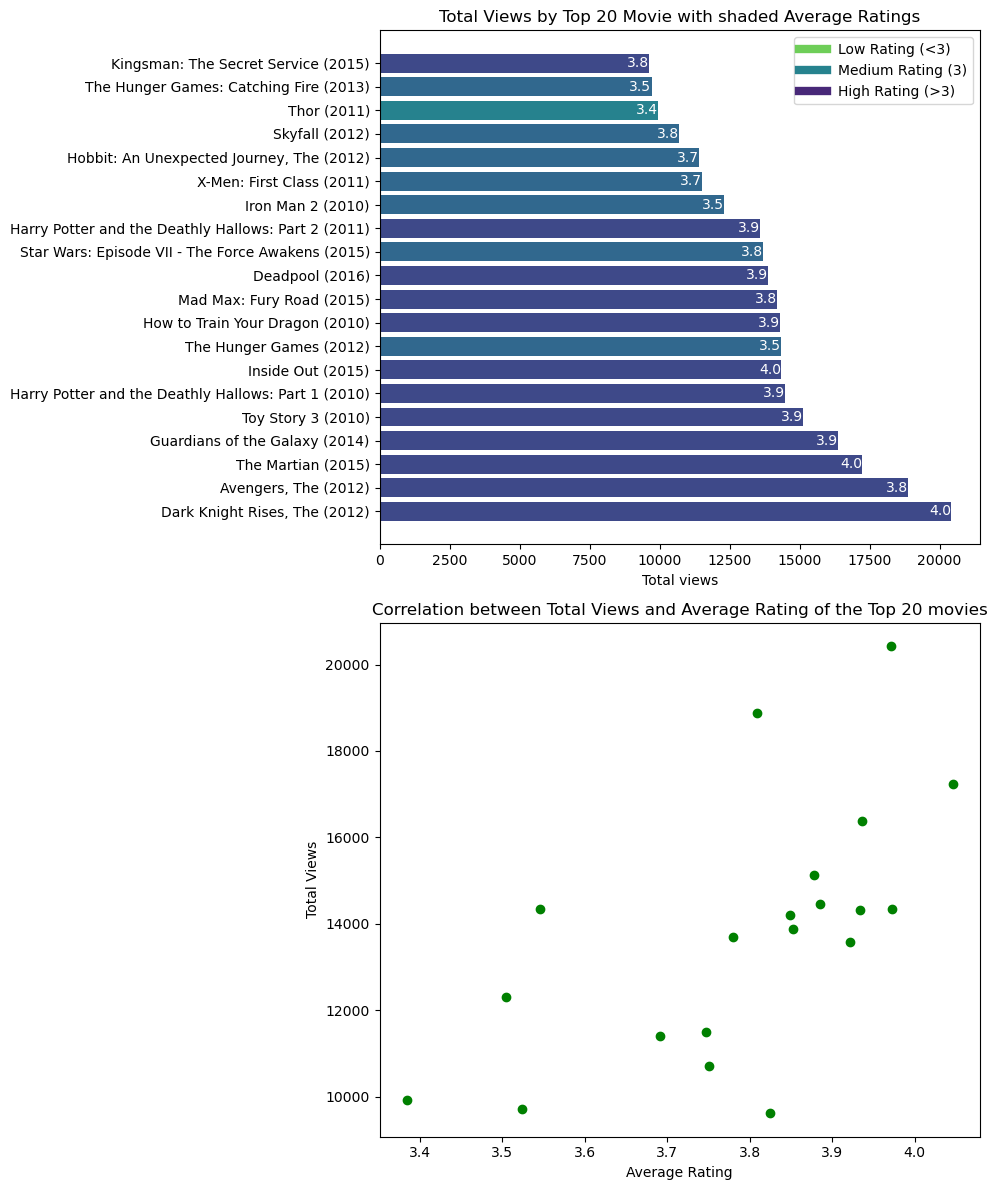

In [75]:
generate_plots(example_agg, decade)

In [76]:
def generate_plots(movies_df: pd.DataFrame, decade: int, top: int = 20):
    """
    Use to generate insights based on movies_df. By default, the insights will be generated based on the top 20 movies. 
    """

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.cm import ScalarMappable
    from wordcloud import WordCloud

    # Sample data
    movies_df = movies_df.sort_values(by="total_views", ascending=False).head(top)

    # Define colors for shading based on ratings
    cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades
    ratings = movies_df["average_rating"]  # Ratings data from your dataframe
    normalized_ratings = (ratings - 1) / 4  # Normalize ratings to range [0,1]
    colors = cmap.reversed()(normalized_ratings)  # Reverse the colormap

    # Create a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Plot the horizontal bar chart on the first subplot
    barh = axs[0].barh(movies_df["title"], movies_df["total_views"], color=colors)
    axs[0].set_xlabel('Total views')
    axs[0].set_title(f'Total Views by Top {top} Movie with shaded Average Ratings')

    # Create a custom legend for the first subplot
    legend_labels = [plt.Line2D([0], [0], color=cmap.reversed()(0.2), lw=6),
                     plt.Line2D([0], [0], color=cmap.reversed()(0.5), lw=6),
                     plt.Line2D([0], [0], color=cmap.reversed()(0.8), lw=6)]
    legend_texts = ['Low Rating (<3)', 'Medium Rating (3)', 'High Rating (>3)']
    axs[0].legend(legend_labels, legend_texts, loc='upper right')

    # Add rating labels inside the bars in the first subplot
    for i, bar in enumerate(barh):
        rating = movies_df.iloc[i]["average_rating"]
        axs[0].text(bar.get_width() - 0.2, bar.get_y() + bar.get_height() / 2, f"{rating:.1f}",
                    color='white', ha='right', va='center')

    # Plot the scatter plot on the second subplot
    axs[1].scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"],
                   movies_df.sort_values(by="total_views", ascending=False)["total_views"], color="green")
    axs[1].set_xlabel("Average Rating")
    axs[1].set_ylabel("Total Views")
    axs[1].set_title(f"Correlation between Total Views and Average Rating of the Top {top} movies")

    # Generate the word cloud from the "tags" column on the third subplot
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(movies_df['tags'].explode().dropna()))

    # Plot the word cloud on the third subplot
    axs[2].imshow(wordcloud, interpolation='bilinear')
    axs[2].axis('off')
    axs[2].set_title(f'Word Cloud of Tags for Top {top} Movies')

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show


/var/folders/7h/4bpx64_97yb6d8pfkbnq3vjw0000gn/T/ipykernel_41416/2040299723.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades


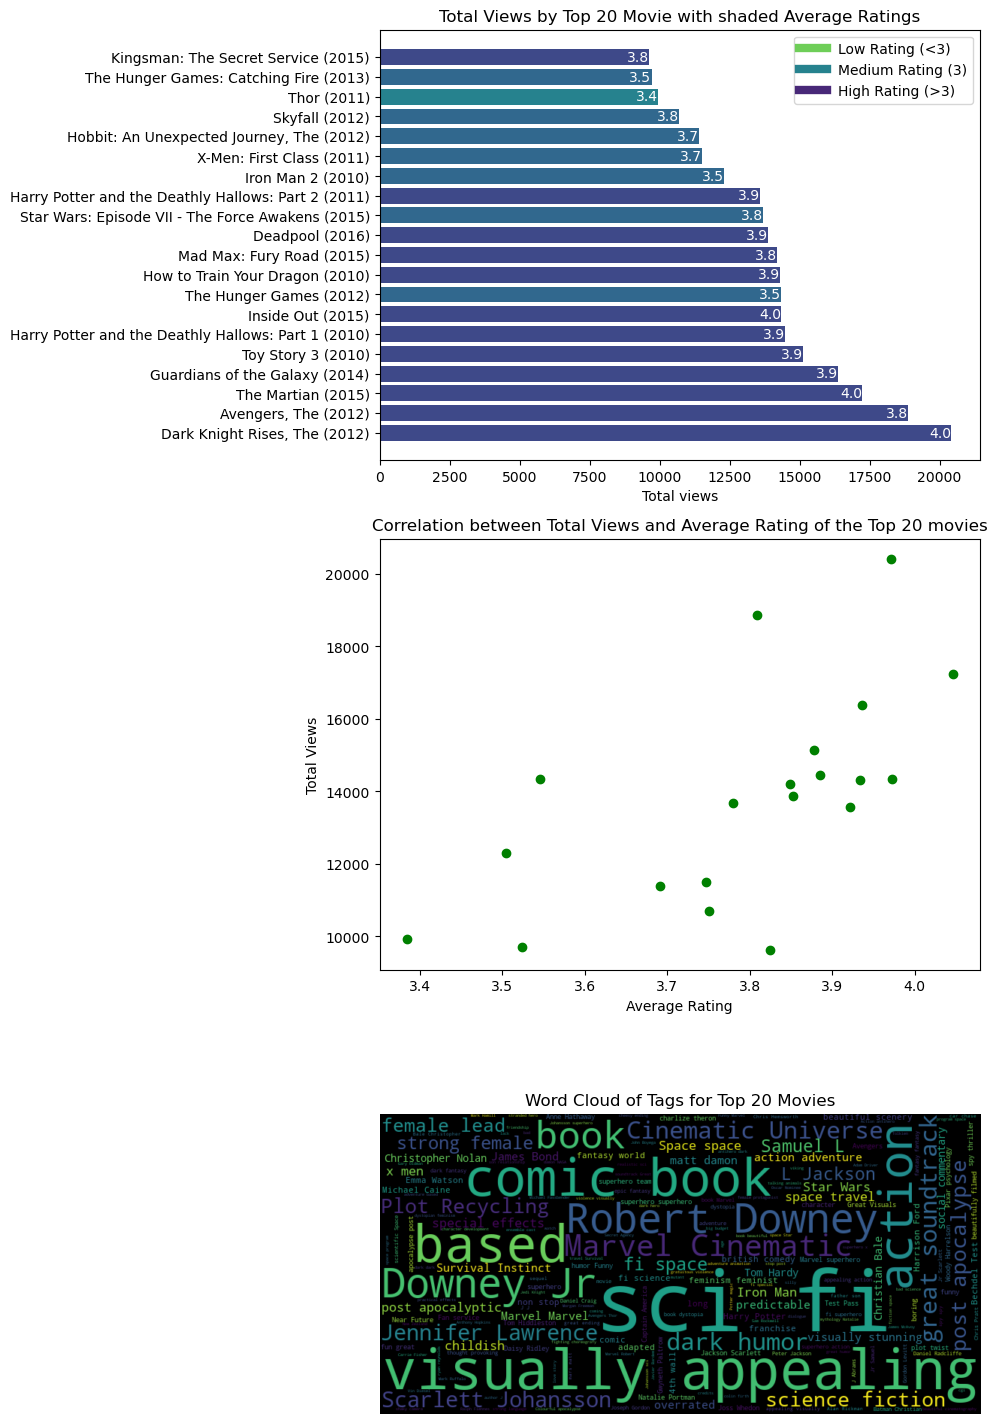

In [77]:
generate_plots(example_agg, decade)

In [ ]:
#what is the most popular movie of all time

# top_20_movies_all_time = df_complete.movieId.value_counts().head(20)

count_movies = df_complete.movieId.value_counts()

# sort by movieId
# df_complete.sort_val(by="movieId")




In [ ]:
# top_movies = df_complete.copy()

# for movies in top_20_movies_all_time:
#     title = top_movies.loc[top_movies["movieId"] == movies, "title"]
#     print(movies)
#     #Top_20 = pd.DataFrame({'Movie': title, 'count': top})

In [ ]:
# count_movies = pd.DataFrame({"total_views": count_movies})

count_movies = pd.DataFrame(count_movies)

count_movies = count_movies.rename(columns={"movieId": "total_views"})

count_movies

rating_means = pd.DataFrame(ratings_df.groupby("movieId")["rating"].mean())

rating_means


In [ ]:
movies_df = pd.merge(movies_df, count_movies, left_on="movieId", right_on=count_movies.index)

movies_df = pd.merge(movies_df,  rating_means, on="movieId")

In [ ]:
# movies_df["genres_list"] = movies_df["movieId"].map(lambda x : genres_per_movie_dict[x])

# movies_df["genres"] = movies_df["genres"].str.split("|")


In [ ]:
movies_df

Most watched movies of all times

In [ ]:
most_watched_df = movies_df.sort_values(by="total_views", ascending=False).head(20)

most_watched_df

In [ ]:
plt.bar(most_watched_df["title"], most_watched_df["rating"])

plt.title("average ratings per most watched movies")
plt.ylabel("average ratings")
plt.xticks(rotation= 90)

In [ ]:
#which genre is rated the highest?

#what is the best combination of genres?


#which

In [ ]:
# ratings vs total views

plt.scatter(movies_df["rating"], movies_df["total_views"])

In [ ]:
display(movies_df.loc[(movies_df["total_views"] > 50000) & (movies_df["rating"] > 3.8)])

In [ ]:
genres_df = movies_df.copy()

# genres_per_movie_df

genres_df = genres_df.explode("genres")

In [ ]:
len(movies_df["genres"].unique())

In [ ]:
genres_df["genres"].unique()

In [ ]:
genres_df[genres_df["total_views"]]

In [ ]:
genres_overview_df = genres_df.copy()

genres_overview_df["genres"].value_counts().plot(kind="bar")

plt.ylabel("views")
plt.title("number of views per genres - all time")